In [240]:
# common imports
import numpy as np
import pandas as pd
import os, cv2, joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit

# global variables
global ROWS, COLUMNS, CHANNELS
CLASSES = {0: 'cat', 1: 'dog'}

# display setup
sns.set(style="whitegrid")  # for plots

# Preface
* Dogs vs. Cats is a dataset containing 25,000 samples.
* Each sample is a colored image (JPEG file) of a dog or a cat. The image sizes vary, so they need to be scaled to the same size.
* The data contains two labels (mentioned in each image file's name), making this a **binary classification** problem.
In other words, this is a **supervised learning** task.
* The model will be trained using all available data and run without learning anymore. This method is named **offline/batch learning**.
* Main objective: Find the best algorithm and model parameters that classify the unused images correctly.

# 1. Getting the Data

In [241]:
path = r"dogs-vs-cats\train/"

images = [path + i for i in os.listdir(path)]
# listdir returns a list with the file names in the given directory

fig = plt.figure(figsize=(10, 7))

for i in range(6):
    plt.subplot(330 + i + 1)
    if i < 3:
        filename = train_path + 'cat.' + str(i) + '.jpg'
    else:
        filename = train_path + 'dog.' + str(i - 3) + '.jpg'
    image = cv2.imread(filename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
fig.suptitle("Dogs vs. Cats Original Samples", size=30)
plt.tight_layout()
plt.show()

In [242]:
def load_dogs_vs_cats(image_dir):
    images_lst = [image_dir + i for i in os.listdir(image_dir)]
    # listdir returns a list with the file names in the given directory
    y = []
    path = []
    for i, image_path in enumerate(images_lst):
        path.append(image_path)
        if '/dog' in image_path:
            y.append(1)
        elif '/cat' in image_path:
            y.append(0)
        else:  # if needed for the test set on kaggle (each image has an id instead of a class)
            y.append(image_path.split('/')[-1].split('.')[0])
    return pd.DataFrame({"path": path, "label": y})

In [243]:
df = load_dogs_vs_cats(path)

In [244]:
df.head()

,path,label
0,dogs-vs-cats\train/cat.0.jpg,0
1,dogs-vs-cats\train/cat.1.jpg,0
2,dogs-vs-cats\train/cat.10.jpg,0
3,dogs-vs-cats\train/cat.100.jpg,0
4,dogs-vs-cats\train/cat.1000.jpg,0


In [245]:
df.isna().sum().sum()

0

In [246]:
df['label'].value_counts()

0    12500
1    12500
Name: label, dtype: int64

In [247]:
# use groupby to locate instances for each label
label_groups = df.groupby('label')

In [248]:
# 3 cat image samples
sample0 = label_groups.get_group(0)[:3]
sample0

,path,label
0,dogs-vs-cats\train/cat.0.jpg,0
1,dogs-vs-cats\train/cat.1.jpg,0
2,dogs-vs-cats\train/cat.10.jpg,0


In [249]:
# 3 dog image samples
sample1 = label_groups.get_group(1)[:3]
sample1

,path,label
12500,dogs-vs-cats\train/dog.0.jpg,1
12501,dogs-vs-cats\train/dog.1.jpg,1
12502,dogs-vs-cats\train/dog.10.jpg,1


In [250]:
# combine cat and dog samples as one DataFrame
sample_images = pd.concat([sample0, sample1], ignore_index=True)

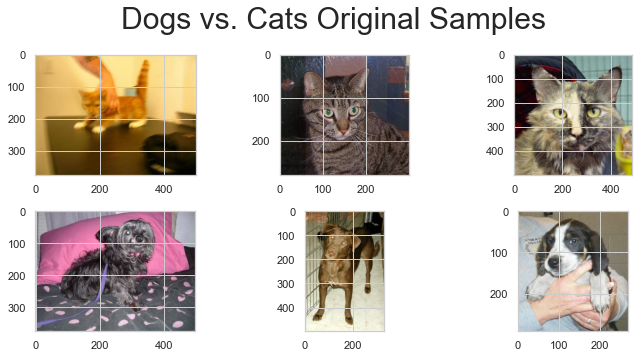

In [251]:
fig = plt.figure(figsize=(10, 7))

for i in range(len(sample_images)):
    plt.subplot(330 + i + 1)
    filename = sample_images['path'][i]
    image = cv2.imread(filename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
fig.suptitle("Dogs vs. Cats Original Samples", size=30)
plt.tight_layout()
plt.show()

> Initial Observations:
>> * The dogs and cats are in different angles. Some are cropped in a way that only the face is seen,
>> others of the whole body.
>> * The photos may also include a person or surrounding objects (i.e. in the bottom right image the
> dog is held by a person).
>> The photos could also be blurry (i.e. in the top left photo it looks like the camera was slightly
>> moved while taking the photo).
>> * There are various image sizes.
>> In order to use the data for ML algorithms, all images need to be processed into an array containing the same pixel values.
>> * The images are in color, meaning the number of pixels chosen for the width and height will be multiplied by 3.
>> This should be taken into account since it adds a substantial amount of features, as opposing to using grayscale images.
>
> The following functions will read the data, and turn it into a DataFrame.
> When implementing these functions, I took into account that rescaling the images and loading new data could be needed
> further on. (Necessary tweaks implemented in the code according to these measures).
>
> Note: The default rescaled size of the images is 64x64x3. This will likely change later on.

>| ### Splitting the Data:
>> Before further analysis let's split the data into a training set and a testing set.
>> This will ensure avoidance of bias that could occur from learning the data as a whole.

The training and testing data should be representative of both classes.
I noticed that the number of samples for dogs and cats are equal and decided a stratified
split is the optimal choice.
Although regular random sampling would have split the data nearly equally, there would
have been more bias towards one of the classes.

In [252]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['label']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [253]:
strat_test_set['label'].value_counts() / len(strat_test_set)

1    0.5
0    0.5
Name: label, dtype: float64

# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [290]:
# deep copy of the training set
df2 = strat_train_set.copy()

In [291]:
df2.head(2)

,path,label
20022,dogs-vs-cats\train/dog.5518.jpg,1
4993,dogs-vs-cats\train/cat.3241.jpg,0


In [277]:
def image_shape(image_path):
    return cv2.imread(image_path).shape


def load_data_shapes(image_file_names):
    shapes = []
    for i, image_file in enumerate(image_file_names):
        shapes.append(image_shape(image_file))
    return shapes

In [278]:
image_shapes = load_data_shapes(strat_train_set['path'])

In [293]:
image_res_df = pd.DataFrame(image_shapes, columns=['height', 'width', 'n_channels'])
image_res_df.head(3)

,height,width,n_channels
0,138,129,3
1,374,500,3
2,438,349,3


df2['label'].reset_index(drop=True)

new_df = pd.DataFrame(image_shapes, columns=['height', 'width', 'n_channels']).join(df2['label'].reset_index(drop=True))
new_df.head(2)

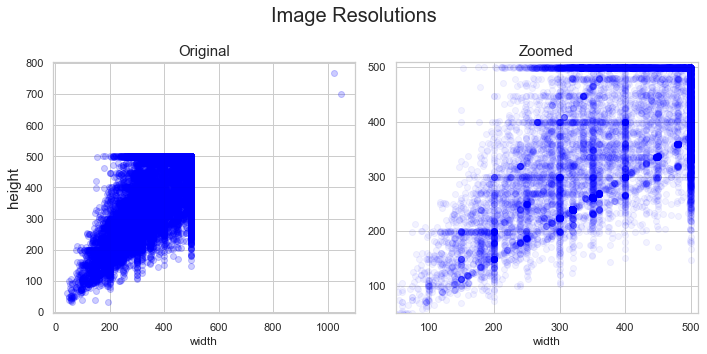

In [340]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(image_res_df.width, image_res_df.height, color='blue', alpha=0.2)
ax1.set_title("Original", size=15)
points = ax2.scatter(image_res_df.width, image_res_df.height, color='blue', alpha=0.05)
ax1.set_xlabel("width")
ax1.set_ylabel("height", size=15)
ax2.set_xlim(xmin=50, xmax=510)
ax2.set_ylim(ymin=50, ymax=510)
ax2.set_title("Zoomed", size=15)
ax2.set_xlabel("width")
fig.suptitle("Image Resolutions", size=20)
plt.tight_layout()
plt.show()

> Observations:
>> * Most image resolutions are less than 500 by 500. There is also a fair amount around 400x400,
>> 300x300, and 200x200.
>> * Rescaling the images to 200x200 seems to be the best option for maintainable amount of features
>> that also reflects the data.
>> * After rescaling, the number of features will be 200x200x3 = 120,000.
>
> Note: The global variables (instantiated below the imports) have been set to these values.

### Pre-processing Implementations:
1. Use grayscale images (has one channel so there are fewer features).
2. Dimensionality reduction using PCA (the color images have 200x200x3=120,000 features!).
3. K-Means for image segmentation.
4. Dimensionality reduction using K-Means.

**To help determine which pre-processing is the best, I will train a couple baseline models on each
of them and compare the results.**

> Why was this necessary?
>
> In order to use the data for ML algorithms, all images need to be processed into an array containing the same pixel values.
> The following functions do just that:

train_groups = strat_train_set.groupby('label')
train_dogs = train_groups.get_group(1)
train_cats = train_groups.get_group(0)

sample_dog = train_dogs['path'][:1].iloc[0]
sample_cat = train_cats['path'][0:1].iloc[0]

cat_img = cv2.imread(sample_cat, cv2.IMREAD_COLOR)
cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
cat_resize = cv2.resize(cat_img, (200,200), interpolation=cv2.INTER_CUBIC)
cat_gray = cv2.cvtColor(cat_resize, cv2.COLOR_RGB2GRAY)

dog_img = cv2.imread(sample_dog, cv2.IMREAD_COLOR)
dog_img = cv2.cvtColor(dog_img, cv2.COLOR_BGR2RGB)
dog_resize = cv2.resize(dog_img, (200,200), interpolation=cv2.INTER_CUBIC)
dog_gray = cv2.cvtColor(dog_resize, cv2.COLOR_RGB2GRAY)

plt.imshow(dog_img, cmap='gray')


In [257]:
def set_params(n_rows, n_cols, n_channels):
    global ROWS, COLUMNS, CHANNELS
    ROWS = n_rows
    COLUMNS = n_cols
    CHANNELS = n_channels


def read_resize_img(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    if CHANNELS == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#        thresh = 128
#        img = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)[1]
    return cv2.resize(img, (ROWS, COLUMNS), interpolation=cv2.INTER_CUBIC)


def prep_data(images, n_rows, n_cols, n_channels):
    set_params(n_rows, n_cols, n_channels)
    m = len(images)
    n_pixels = ROWS * COLUMNS * CHANNELS
    X = np.ndarray((m, n_pixels), dtype=np.uint8)
    y = np.zeros((m, 1))
    #    path = []  # saving the path ensures we can load each image again in case rescaling is required

    # enumerate() function iterates the input object ('images') by using two variables:
    # i is the count of the current iteration
    # img_file is the path of the image file at the current iteration
    for i, img_file in enumerate(images):
        img = read_resize_img(img_file)
        X[i, :] = np.squeeze(img.reshape((n_pixels, 1)))  # squeeze removes useless one-dimensional arrays
        #        path.append(img_file)

        if '/dog' in img_file:
            y[i, 0] = 1
        elif '/cat' in img_file:
            y[i, 0] = 0
        else:  # if needed for the test set on kaggle (each image has an id instead of a class)
            y[i, 0] = img_file.split('/')[-1].split('.')[0]
        if i % 5000 == 0:
            print("Loading: {}/{}".format(i, m))  # print loading progress
    print("Finished Loading Data")
    return X, y

In [341]:
set_params(200,200,3)

In [258]:
X_train, y_train = prep_data(strat_train_set['path'], 200, 200, 3)

Loading: 0/20000
Loading: 5000/20000
Loading: 10000/20000
Loading: 15000/20000
Finished Loading Data


joblib.dump(X_train, 'dogs-vs-cats/X_train' + '.z', compress=3)
joblib.dump(y_train, 'dogs-vs-cats/y_train' + '.z', compress=3)

X_train = joblib.load(r'dogs-vs-cats/X_train.z')

y_train = joblib.load(r'dogs-vs-cats/y_train.z')

In [259]:
X_train_gray, y_train = prep_data(strat_train_set['path'], 200, 200, 1)

Loading: 0/20000
Loading: 5000/20000
Loading: 10000/20000
Loading: 15000/20000
Finished Loading Data


In [260]:
X_train_gray.shape

(20000, 40000)

In [261]:
X_train_gray

array([[196, 199, 204, ...,  71,  67,  66],
       [120, 123, 124, ...,  85,  96,  97],
       [130, 134, 139, ...,  85, 132, 164],
       ...,
       [ 57,  63,  63, ..., 143, 141, 142],
       [ 41,  41,  42, ...,  47,  68,  73],
       [ 14,  14,  14, ..., 134, 137, 144]], dtype=uint8)

plt.imshow(X_train_gray[5].reshape((200,200,1)))

plt.imshow(X_train_gray[5].reshape((200,200,1)))

In [342]:
img1_before = strat_train_set['path'][0:1].iloc[0]
img1_after = X_train[0]
img1_after = img1_after.reshape((ROWS, COLUMNS, CHANNELS))
img2_before = strat_train_set['path'][1:2].iloc[0]
img2_after = X_train[1]
img2_after = img2_after.reshape((ROWS, COLUMNS, CHANNELS))

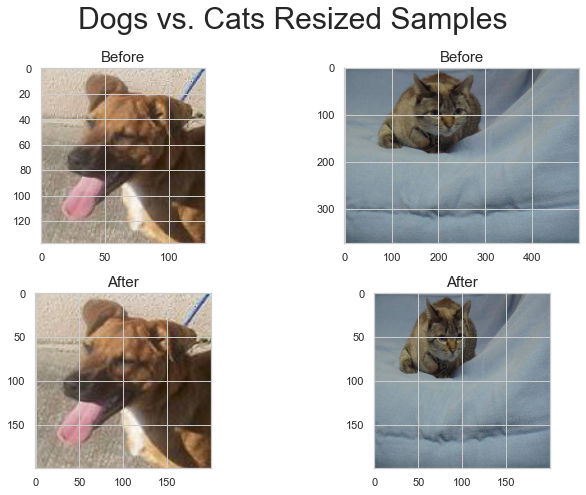

In [343]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(2, 2, 1)
image = cv2.imread(img1_before)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Before', size=15)
fig.add_subplot(2, 2, 3)
plt.imshow(img1_after)
plt.title('After', size=15)
fig.add_subplot(2, 2, 2)
image = cv2.imread(img2_before)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Before', size=15)
fig.add_subplot(2, 2, 4)
plt.imshow(img2_after)
plt.title('After', size=15)
fig.suptitle("Dogs vs. Cats Resized Samples", size=30)
plt.tight_layout()
plt.show()

X_train_gray, y_train_gray = prep_data(strat_train_set['path'], 200, 200, 1)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train_scaled = StandardScaler().fit_transform(X_train)

In [ ]:
joblib.dump(X_train_scaled, 'dogs-vs-cats/X_train_scaled' + '.z', compress=6)

In [235]:
X_train_scaled = joblib.load(r'dogs-vs-cats/X_train_scaled.z')

In [ ]:
X_train_scaled

In [5]:
X_train_scaled.shape

(20000, 120000)

In [6]:
y_train.flatten().shape

(20000,)

In [10]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42, n_jobs=-1)

log_reg.fit(X_train_gray, y_train.ravel())

predictions = log_reg.predict(X_train_gray)

In [ ]:
from sklearn import metrics

In [7]:
# function prints scores
def display_evaluation(actual, pred):
    print("Confusion Matrix:\n", metrics.confusion_matrix(actual, pred), "\n")
    print("Classification Report:\n", metrics.classification_report(actual, pred))

display_evaluation(y_train, predictions)

log_reg_2 = LogisticRegression(random_state=42, n_jobs=-1)
log_reg_2.fit(X_train_scaled, y_train.ravel())

In [8]:
from sklearn.model_selection import cross_val_score

In [ ]:
log_reg_cv = cross_val_score(log_reg, X_train_scaled, y_train.flatten(), n_jobs=-1, cv=5, scoring='accuracy')

In [ ]:
# function for evaluating cross validation scores and for easy model comparison
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [ ]:
display_scores(log_reg_cv)

-------------------------

def read_resize_img(file_path, color):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    if color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.resize(img, (ROWS, COLUMNS), interpolation=cv2.INTER_CUBIC)

def prep_data(images, color):
    m = len(images)
    n_pixels = ROWS * COLUMNS * CHANNELS
    X = np.ndarray((m, n_pixels), dtype=np.uint8)
    y = np.zeros((m, 1))
    path = []  # saving the path ensures we can load each image again in case rescaling is required

    # enumerate() function iterates the input object ('images') by using two variables:
    # i is the count of the current iteration
    # img_file is the path of the image file at the current iteration
    for i, img_file in enumerate(images):
        img = read_resize_img(img_file, color)
        X[i, :] = np.squeeze(img.reshape((n_pixels, 1)))  # squeeze removes useless one-dimensional arrays
        path.append(img_file)

        if '/dog' in img_file:
            y[i, 0] = 1
        elif '/cat' in img_file:
            y[i, 0] = 0
        else:  # if needed for the test set on kaggle (each image has an id instead of a class)
            y[i, 0] = img_file.split('/')[-1].split('.')[0]
        if i % 5000 == 0:
            print("Loading: {}/{}".format(i, m))  # print loading progress
    print("Finished Loading Data")
    return X, y, path

def load_data(img_dir, n_rows, n_cols, color):
    global ROWS, COLUMNS, CHANNELS
    ROWS = n_rows
    COLUMNS = n_cols
    if color:
        CHANNELS = 3
    else:
        CHANNELS = 1
    X, y, path = prep_data(img_dir, color)
    print("Converting to DataFrame")
    # create a DataFrame including a column for file path and labels
    df = pd.concat([pd.DataFrame(path, columns=['path']), pd.DataFrame(y, columns=['label']), pd.DataFrame(X)], axis=1)
    return df

df = load_data(images, n_rows=200, n_cols=200, color=True)

df.head()

In [ ]:
# check if all values are in DataFrame, merely a precaution after this data processing
# np.isnan checks if the element is is not a number
# df.values returns a numpy array containing the data without index or column names
# (like X shown above with an additional value in each row for the label)
# sum() returns the absolute amount missing
# np.isnan(df.values).sum()
df.isna().sum().sum()

In [ ]:
def show_images(X, y, index):
    image = X[index]
    image = image.reshape((ROWS, COLUMNS, CHANNELS))
    plt.figure(figsize=(6, 3))
    plt.imshow(image)
    plt.title("This is a {}".format(CLASSES[y[index, 0]]))
    plt.axis('off')
    plt.show()

In [ ]:
# for i in range(11):
# show_images(X, labels, i)

In [ ]:
# use groupby to locate instances for each label
label_groups = df.groupby('label')

In [ ]:
# 3 cat image samples
sample0 = label_groups.get_group(0)[:3].drop(['path', 'label'], axis=1)
sample0

In [ ]:
# 3 dog image samples
sample1 = label_groups.get_group(1)[:3].drop(['path', 'label'], axis=1)
sample1

In [ ]:
df['label'].value_counts()

> Observations:
>> * By looking at the index numbers for each group, the first instance labeled 1 (dog) is located at index 12500.
>> My assumption was that all cat images were the first 12,500 samples, with the rest as dogs.
>> To validate my assumptions I counted the values for each class.
>> * Why is this important? Data arranged by class order could result in poor performance of the ML algorithms,
>> an unrepresentative test set or cross-validation folds later on (i.e., a test set containing only cat images).
>> * Solution: The train_test_split() is a random sampling method, so it takes care of this.
>> The random_state parameter ensures that the generated shuffled split is the same each time.
>

In [ ]:
# combine cat and dog samples as one DataFrame
sample_images = pd.concat([sample0, sample1], ignore_index=True)

In [ ]:
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 3

# add sample image in each iteration
for i in range(rows * columns):
    image = sample_images[i:i + 1].to_numpy().reshape((ROWS, COLUMNS, CHANNELS))
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')
fig.suptitle("Dogs vs. Cats Resized Samples", size=30)
plt.tight_layout()
plt.show()

> ### Splitting the Data:
>> Before further analysis let's split the data into a training set and a testing set.
>> This will ensure avoidance of bias that could occur from learning the data as a whole.

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

joblib.dump(train_set, 'dogs-vs-cats/train_set')
joblib.dump(test_set, 'dogs-vs-cats/test_set')

# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [ ]:
df2 = joblib.load(r'dogs-vs-cats/train_set')

# deep copy of the training set
df2 = train_set.copy()

In [ ]:
df2.head(2)

In [ ]:
train_gray = load_data((df2['path']), n_rows=ROWS, n_cols=COLUMNS, color=False)

In [ ]:
train_gray.head(2)

In [ ]:
df2

In [103]:
df['path'][0]

'dogs-vs-cats\\train/cat.0.jpg'

In [227]:
img = cv2.imread(df['path'][3], cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_vec = img.reshape(-1, 3)
img_vec = np.float32(img_vec)

In [228]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42).fit(img_vec)

In [229]:
seg_img = kmeans.cluster_centers_[kmeans.labels_]
seg_img = seg_img.reshape(img.shape)
seg_img = seg_img.astype('uint8')

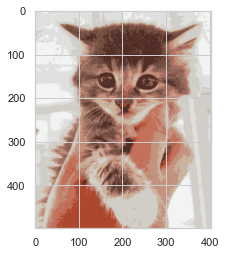

In [230]:
plt.imshow(seg_img)

> #### Resources:
> 1. Dogs vs. Cats Dataset <a href="https://www.kaggle.com/c/dogs-vs-cats"
> title="Kaggle">link</a>
> 2. Loading Data Tutorial <a href="https://medium.com/@mrgarg.rajat/kaggle-dogs-vs-cats-challenge-complete-step-by-step-guide-part-1-a347194e55b1"
> title="medium">link</a>